In [2]:
import pandas as pd #To hand with data 
import numpy as np #To math 
import math
import random
import seaborn as sns #to visualization
import matplotlib.pyplot as plt # to plot the graphs
import matplotlib.gridspec as gridspec # to do the grid of plots

In [3]:
# External node of the tree
class ExNode:
    def __init__(self, size):
        self.size = size

# Internal node of the tree
class InNode:
    def __init__(self, left, right, splitAtt, splitVal):
        self.left = left
        self.right = right
        self.splitAtt = splitAtt
        self.splitVal = splitVal

# Function to create the isolation forest
def iForest(X, noOfTrees, sampleSize):
    forest = []
    hlim = math.ceil(math.log(sampleSize, 2)) # Height limit
    for i in range(noOfTrees): # For each tree
        X_train = X.sample(sampleSize)
        forest.append(iTree(X_train, 0, hlim))
    return forest

# Function to create the isolation tree
def iTree(X, currHeight, hlim):
    if currHeight >= hlim or len(X) <= 1: # If the height limit is reached or the size of the dataset is 1
        return ExNode(len(X)) # Return an external node
    else:
        Q = X.columns # List of features
        q = random.choice(Q) # Randomly select a feature
        p = random.choice(X[q].unique()) # Randomly select a feature and a value from the feature
        X_l = X[X[q] < p] # Left branch of the tree
        X_r = X[X[q] >= p] # Right branch of the tree
        return InNode(iTree(X_l, currHeight + 1, hlim), iTree(X_r, currHeight + 1, hlim), q, p)

# Function to calculate the path length of an instance x
def pathLength(x, Tree, currHeight):
    if isinstance(Tree, ExNode):
        return currHeight
    a = Tree.splitAtt # Attribute at internal node
    if x[a] < Tree.splitVal: # Follow left branch
        return pathLength(x, Tree.left, currHeight + 1) 
    else:
        return pathLength(x, Tree.right, currHeight + 1)

# Function to calculate the anomaly score of the instances
def isolation_forest(df, no_of_trees, sample_size):
    ifor = iForest(df, no_of_trees, sample_size)  # Forest of trees
    anomaly_scores = []
    for _, row in df.iterrows(): # For each instance in the dataset
        path_lengths = []
        for tree in ifor: # For each tree in the forest
            path_lengths.append(pathLength(row, tree, 0))
        anomaly_score = np.mean(path_lengths) # Average of path lengths
        anomaly_scores.append(anomaly_score) # Save the anomaly score of the instance
    return anomaly_scores

In [9]:
#loading the data
df_credit = pd.read_csv("dataset\creditcard.zip")

In [10]:
# Define a function to convert time in seconds to minutes and hours
def convert_time(seconds):
    minutes = seconds // 60
    hours = minutes // 60
    return minutes % 60, hours % 24

# Create empty lists to store the converted values
time_min_values = []
time_hour_values = []

# Apply the conversion function to each time value in the dataframe
for time_sec in df_credit['Time']:
    minutes, hours = convert_time(time_sec)
    time_min_values.append(minutes)
    time_hour_values.append(hours)

# Add the converted values as new columns to the DataFrame
df_credit['Time_min'] = time_min_values
df_credit['Time_hour'] = time_hour_values

#Feature engineering to a better visualization of the values
df_credit['Amount_log'] = np.log(df_credit.Amount + 0.01)
df_credit['Amount'] = df_credit['Amount_log']
df_credit.drop(['Time', 'Amount_log'], axis=1, inplace=True)

In [6]:
df_credit

NameError: name 'df_credit' is not defined

In [11]:
def calculate_confusion_matrix(actual_labels, predicted_labels):
    true_positive = sum((a == 1) and (p == 1) for a, p in zip(actual_labels, predicted_labels))
    false_positive = sum((a == 0) and (p == 1) for a, p in zip(actual_labels, predicted_labels))
    false_negative = sum((a == 1) and (p == 0) for a, p in zip(actual_labels, predicted_labels))
    
    return true_positive, false_positive, false_negative

In [12]:
def calculate_f1_score(true_positive, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    if precision + recall == 0:
        return 0  # To avoid division by zero
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score

In [13]:
def calculate_accuracy(true_labels, predicted_labels):
    correct_predictions = 0
    total_predictions = len(true_labels)
    
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        if true_label == predicted_label:
            correct_predictions += 1
            
    accuracy = correct_predictions / total_predictions
    return accuracy

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import f1_score

df1 = df_credit.sample(15000)

# Create copies of df1 for different experiments
df2 = df1.copy()
df3 = df1.copy()
df4 = df1.drop(columns=['Class']).copy()

# Function to classify based on threshold
def classify_anomaly_score(score, threshold):
    if score <= threshold:
        return 1  # Fraud
    else:
        return 0  # Normal

anomaly_scores = isolation_forest(df2, no_of_trees=100, sample_size=256)
threshold = np.quantile(anomaly_scores, 0.0017)
        
# Classify ano{maly scores
df2['AnomalyScore'] = anomaly_scores
df2['predicted_class'] = df2['AnomalyScore'].apply(lambda score: classify_anomaly_score(score, threshold))

ground_truth_labels = df3['Class']
predicted_class_labels = df2['predicted_class']

precision, recall, _ = precision_recall_curve(ground_truth_labels, predicted_class_labels)

# Calculate AUPR
aupr_score = auc(recall, precision)

true_positive, false_positive, false_negative = calculate_confusion_matrix(ground_truth_labels, predicted_class_labels)
print("True Positives:", true_positive)
print("False Positives:", false_positive)
print("False Negatives:", false_negative)

f1_score = calculate_f1_score(true_positive, false_positive, false_negative)
accuracy = calculate_accuracy(ground_truth_labels, predicted_class_labels)

print("Accuracy:", accuracy)
print("F1 Score :", f1_score)
print("AUPR Score : ", aupr_score)

True Positives: 17
False Positives: 9
False Negatives: 5
Accuracy: 0.9990666666666667
F1 Score : 0.7083333333333333
AUPR Score :  0.71345337995338


[<__main__.InNode object at 0x0000014E609F85E0>, <__main__.InNode object at 0x0000014E609F6FD0>, <__main__.InNode object at 0x0000014E609D8A60>, <__main__.InNode object at 0x0000014E55D5C280>, <__main__.InNode object at 0x0000014E609E4D90>, <__main__.InNode object at 0x0000014E609F3340>, <__main__.InNode object at 0x0000014E609D8910>, <__main__.InNode object at 0x0000014E609D5B80>, <__main__.InNode object at 0x0000014E60A216A0>, <__main__.InNode object at 0x0000014E60A02550>, <__main__.InNode object at 0x0000014E60A1F9A0>, <__main__.InNode object at 0x0000014E60A36610>, <__main__.InNode object at 0x0000014E60A1C910>, <__main__.InNode object at 0x0000014E60963A00>, <__main__.InNode object at 0x0000014E60A51940>, <__main__.InNode object at 0x0000014E609E4370>, <__main__.InNode object at 0x0000014E60A42790>, <__main__.InNode object at 0x0000014E60A61D30>, <__main__.InNode object at 0x0000014E60A12130>, <__main__.InNode object at 0x0000014E609E72E0>, <__main__.InNode object at 0x0000014E60

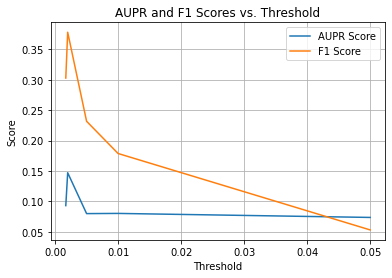

In [13]:
# Function to classify based on threshold
def classify_anomaly_score(score, threshold):
    if score <= threshold:
        return 1  # Fraud
    else:
        return 0  # Normal

values = [0.0017, 0.002, 0.005, 0.01, 0.05]

# Lists to store results
aupr_scores = []
f1_scores = []

df2 = df1.copy()
df2.drop('Class', axis=1, inplace=True)

anomaly_scores = isolation_forest(df2, no_of_trees=100, sample_size=256)
df2['AnomalyScore'] = anomaly_scores

# Loop over different threshold values
for val in values:
    
    threshold = np.quantile(anomaly_scores, val)
    # Classify anomaly scores
    df2['predicted_class'] = df2['AnomalyScore'].apply(lambda score: classify_anomaly_score(score, threshold))
    
    # Calculate AUPR scores
    aupr_score = average_precision_score(df2['predicted_class'], df3['Class'])
    aupr_scores.append(aupr_score)
    
    # Calculate F1 score
    f1 = f1_score(df2['predicted_class'], df3['Class'])
    f1_scores.append(f1)

# Plot AUPR and F1 scores
plt.plot(values, aupr_scores, label='AUPR Score')
plt.plot(values, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('AUPR and F1 Scores vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import f1_score

df1 = df_credit.sample(17000)

# Create copies of df1 for different experiments
df2 = df1.copy()
df3 = df1.copy()
df4 = df1.drop(columns=['Class']).copy()

# Function to classify based on threshold
def classify_anomaly_score(score, threshold):
    if score <= threshold:
        return 1  # Fraud
    else:
        return 0  # Normal

anomaly_scores = isolation_forest(df2, no_of_trees=100, sample_size=256)
threshold = np.quantile(anomaly_scores, 0.0017)
        
# Classify ano{maly scores
df2['AnomalyScore'] = anomaly_scores
df2['predicted_class'] = df2['AnomalyScore'].apply(lambda score: classify_anomaly_score(score, threshold))

ground_truth_labels = df3['Class']
predicted_class_labels = df2['predicted_class']

precision, recall, _ = precision_recall_curve(ground_truth_labels, predicted_class_labels)

# Calculate AUPR
aupr_score = auc(recall, precision)

true_positive, false_positive, false_negative = calculate_confusion_matrix(ground_truth_labels, predicted_class_labels)
print("True Positives:", true_positive)
print("False Positives:", false_positive)
print("False Negatives:", false_negative)

f1_score = calculate_f1_score(true_positive, false_positive, false_negative)
accuracy = calculate_accuracy(ground_truth_labels, predicted_class_labels)

print("Accuracy:", accuracy)
print("F1 Score :", f1_score)
print("AUPR Score : ", aupr_score)

True Positives: 11
False Positives: 19
False Negatives: 21
Accuracy: 0.9976470588235294
F1 Score : 0.3548387096774193
AUPR Score :  0.35582598039215685


In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import f1_score

df1 = df_credit.sample(15000)

# Create copies of df1 for different experiments
df2 = df1.copy()
df3 = df1.copy()
df4 = df1.drop(columns=['Class']).copy()

# Function to classify based on threshold
def classify_anomaly_score(score, threshold):
    if score <= threshold:
        return 1  # Fraud
    else:
        return 0  # Normal

anomaly_scores = isolation_forest(df2, no_of_trees=100, sample_size=256)
threshold = np.quantile(anomaly_scores, 0.0017)
        
# Classify ano{maly scores
df2['AnomalyScore'] = anomaly_scores
df2['predicted_class'] = df2['AnomalyScore'].apply(lambda score: classify_anomaly_score(score, threshold))

ground_truth_labels = df3['Class']
predicted_class_labels = df2['predicted_class']

precision, recall, _ = precision_recall_curve(ground_truth_labels, predicted_class_labels)

# Calculate AUPR
aupr_score = auc(recall, precision)

true_positive, false_positive, false_negative = calculate_confusion_matrix(ground_truth_labels, predicted_class_labels)
print("True Positives:", true_positive)
print("False Positives:", false_positive)
print("False Negatives:", false_negative)

f1_score = calculate_f1_score(true_positive, false_positive, false_negative)
accuracy = calculate_accuracy(ground_truth_labels, predicted_class_labels)

print("Accuracy:", accuracy)
print("F1 Score :", f1_score)
print("AUPR Score : ", aupr_score)

True Positives: 9
False Positives: 17
False Negatives: 12
Accuracy: 0.9980666666666667
F1 Score : 0.3829787234042554
AUPR Score :  0.3877626373626374


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import f1_score

df1 = df_credit.sample(20000)

# Create copies of df1 for different experiments
df2 = df1.copy()
df3 = df1.copy()
df4 = df1.drop(columns=['Class']).copy()

# Function to classify based on threshold
def classify_anomaly_score(score, threshold):
    if score <= threshold:
        return 1  # Fraud
    else:
        return 0  # Normal

anomaly_scores = isolation_forest(df2, no_of_trees=100, sample_size=256)
threshold = np.quantile(anomaly_scores, 0.0017)
        
# Classify anomaly scores
df2['AnomalyScore'] = anomaly_scores
df2['predicted_class'] = df2['AnomalyScore'].apply(lambda score: classify_anomaly_score(score, threshold))

ground_truth_labels = df3['Class']
predicted_class_labels = df2['predicted_class']

precision, recall, _ = precision_recall_curve(ground_truth_labels, predicted_class_labels)

# Calculate AUPR
aupr_score = auc(recall, precision)

true_positive, false_positive, false_negative = calculate_confusion_matrix(ground_truth_labels, predicted_class_labels)
print("True Positives:", true_positive)
print("False Positives:", false_positive)
print("False Negatives:", false_negative)

f1_score = calculate_f1_score(true_positive, false_positive, false_negative)
accuracy = calculate_accuracy(ground_truth_labels, predicted_class_labels)

print("Accuracy:", accuracy)
print("F1 Score :", f1_score)
print("AUPR Score : ", aupr_score)

True Positives: 13
False Positives: 21
False Negatives: 21
Accuracy: 0.9979
F1 Score : 0.3823529411764706
AUPR Score :  0.38287794117647056


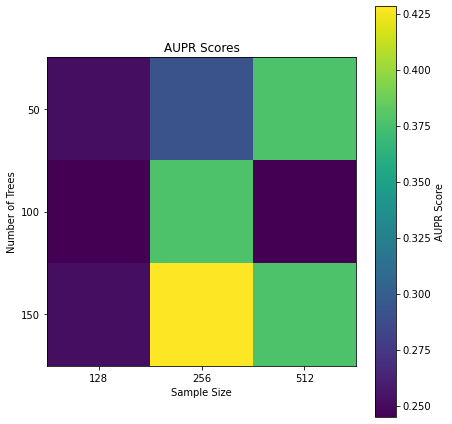

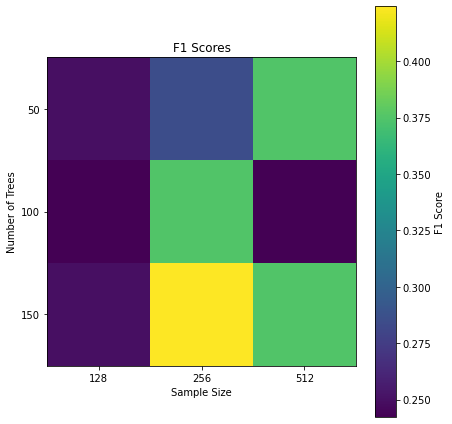

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import f1_score

df1 = df_credit.sample(10000)

# Create copies of df1 for different experiments
df2 = df1.copy()
df3 = df1.copy()
df4 = df1.drop(columns=['Class']).copy()

# Function to classify based on threshold
def classify_anomaly_score(score, threshold):
    if score <= threshold:
        return 1  # Fraud
    else:
        return 0  # Normal

# Lists to store results
no_of_trees_list = [50, 100, 150]
sample_size_list = [128, 256, 512]
aupr_scores = []
aupr_scores_1 = []
f1_scores = []

# Loop over different values of number of trees and sample size
for no_of_trees in no_of_trees_list:
    for sample_size in sample_size_list:
        # Fit Isolation Forest
        df2 = df1.copy()
        df2.drop('Class', axis=1, inplace=True)
        
        # Calculate anomaly scores
        anomaly_scores = isolation_forest(df2, no_of_trees=no_of_trees, sample_size=sample_size)
        
        # Calculate threshold
        threshold = np.quantile(anomaly_scores, 0.0017)
        
        # Classify anomaly scores
        df2['AnomalyScore'] = anomaly_scores
        df2['predicted_class'] = df2['AnomalyScore'].apply(lambda score: classify_anomaly_score(score, threshold))
        
        ground_truth_labels = df3['Class']
        predicted_class_labels = df2['predicted_class']

        precision, recall, _ = precision_recall_curve(ground_truth_labels, predicted_class_labels)

        # Calculate AUPR
        aupr_score = auc(recall, precision)
        aupr_scores.append(aupr_score)
        
        f1 = f1_score(ground_truth_labels, predicted_class_labels)
        f1_scores.append(f1)

# Reshape the AUPR scores for plotting
aupr_scores = np.array(aupr_scores).reshape(len(no_of_trees_list), len(sample_size_list))
f1_scores = np.array(f1_scores).reshape(len(no_of_trees_list), len(sample_size_list))

# Plot AUPR scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(aupr_scores, cmap='viridis', interpolation='nearest')
plt.title('AUPR Scores')
plt.xlabel('Sample Size')
plt.ylabel('Number of Trees')
plt.xticks(np.arange(len(sample_size_list)), sample_size_list)
plt.yticks(np.arange(len(no_of_trees_list)), no_of_trees_list)
plt.colorbar(label='AUPR Score')
plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.imshow(f1_scores, cmap='viridis', interpolation='nearest')
plt.title('F1 Scores')
plt.xlabel('Sample Size')
plt.ylabel('Number of Trees')
plt.xticks(np.arange(len(sample_size_list)), sample_size_list)
plt.yticks(np.arange(len(no_of_trees_list)), no_of_trees_list)
plt.colorbar(label='F1 Score')
plt.tight_layout()

plt.show()


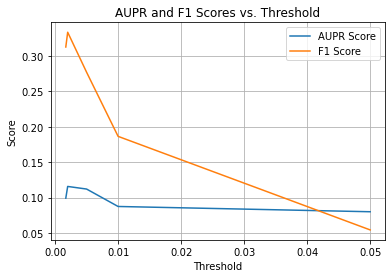

In [20]:
# Function to classify based on threshold
def classify_anomaly_score(score, threshold):
    if score <= threshold:
        return 1  # Fraud
    else:
        return 0  # Normal

values = [0.0017, 0.002, 0.005, 0.01, 0.05]

# Lists to store results
aupr_scores = []
f1_scores = []

df2 = df1.copy()
df2.drop('Class', axis=1, inplace=True)

anomaly_scores = isolation_forest(df2, no_of_trees=100, sample_size=256)
df2['AnomalyScore'] = anomaly_scores

# Loop over different threshold values
for val in values:
    
    threshold = np.quantile(anomaly_scores, val)
    # Classify anomaly scores
    df2['predicted_class'] = df2['AnomalyScore'].apply(lambda score: classify_anomaly_score(score, threshold))
    
    # Calculate AUPR scores
    aupr_score = average_precision_score(df2['predicted_class'], df3['Class'])
    aupr_scores.append(aupr_score)
    
    # Calculate F1 score
    f1 = f1_score(df2['predicted_class'], df3['Class'])
    f1_scores.append(f1)

# Plot AUPR and F1 scores
plt.plot(values, aupr_scores, label='AUPR Score')
plt.plot(values, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('AUPR and F1 Scores vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()